# DATA 620 - Project 3

Jeremy OBrien, Mael Illien, Vanita Thompson

### Name Gender Classifier

* Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. 
* Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. 
* Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. 
* Once you are satisfied with your classifier, check its final performance on the test set. 
* How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?
* Source: Natural Language Processing with Python, exercise 6.10.2.

## Setup

For this project, we work with the 'names' corpus contained within NLTK.

We start our work by restructing some of the guidelines from Chapter 6 of our text. The function 'test_classifier' performs most of the work: splitting the data into train and test sets, extracting features, training the model, and predicting based on the test set. 

In the feature engineering section, we build on examples from the text and develop new features to evaluate. 

We study each of the three classifiers described in the text - NaiveBayes, DecisionTree, and MaxEntropy - in their respective sections, and compare results in a summary table in the conclusion.

In [1]:
import random
import pandas as pd
import nltk, re, pprint
from nltk.corpus import names
from nltk.classify import apply_features
from IPython.display import display, HTML

For ease of comparison, we compile a list of the models created for this project and their performance.

In [2]:
models = [] # Will contain tuples (classifier, class_name, gf_name, acc_devtest, acc_test)

## Data Import & Transformation

The NLTK 'names' corpus contains both male and female names in separate text files. The code below extracts the names from both files, assigns a gender to the name, and stores the information in a list of tuples. The labeled names are shuffled to randomize their distribution over the train and test sets.

In [3]:
# Build dataset removing any white space and names with hyphens
labeled_names = ([(name.lower().strip(), 'male') for name in names.words('male.txt') if name.isalpha()] + 
         [(name.lower().strip(), 'female') for name in names.words('female.txt') if name.isalpha()])

random.seed(620)
random.shuffle(labeled_names)
labeled_names[:10]

[('marietta', 'male'),
 ('price', 'male'),
 ('almeda', 'female'),
 ('hendrika', 'female'),
 ('reggie', 'male'),
 ('mindy', 'female'),
 ('cosette', 'female'),
 ('logan', 'male'),
 ('martha', 'female'),
 ('ulrika', 'female')]

In [4]:
len(labeled_names)

7904

### Test Classifier

The **test_classifier** function takes as arguments a corpus of labeled names, a function to extract features from that corpus, and a classifier type. It splits the datasets into three parts: a training set, a devtest set, and a test set. It trains the classifier and returns the model and its accuracy on both test sets. This information is made available to compare between approaches to feature engineering and model types.

In [1]:
def test_classifier(names_corpus, gender_features_function, classifier_type):

    # Train test split (corrected)
    train_names = names_corpus[1000:]
    devtest_names = names_corpus[0:500]
    test_names = names_corpus[500:1000]
    
    # Apply features
    train_set = [(gender_features_function(n), gender) for (n, gender) in train_names]
    devtest_set = [(gender_features_function(n), gender) for (n, gender) in devtest_names]
    test_set = [(gender_features_function(n), gender) for (n, gender) in test_names]
    
    # Classify and print score; if Maximum Entropy, use trace to limit diagnostic output on screen
    if classifier_type == nltk.ConditionalExponentialClassifier:
        classifier = classifier_type.train(train_set, trace=0)
    else:
        classifier = classifier_type.train(train_set)
    acc_devtest = round(nltk.classify.accuracy(classifier, devtest_set), 3)
    acc_test = round(nltk.classify.accuracy(classifier, test_set), 3)
    print('Dev test set accuracy: ' + str(acc_devtest))
    print('Test set accuracy: ' + str(acc_test))
    
    #classifier.show_most_informative_features(5)
    
    class_name = classifier_type.__name__
    gf_name = gender_features_function.__name__
    models.append((classifier, class_name, gf_name, acc_devtest, acc_test))
    
    return classifier  

## Feature Engineering

We explore a number of approaches to breaking down first names and extracting features to train the classifier model. These different approaches may lend the classifiers more or less power to efficiently discriminate between female and male names.

We include features defined in the text and augment them with additional appraoches.

**Approach \#1**:  The last letter of the name. While a simple approach, the particular letter at the end of a name can be powerful predictor of gender.

In [6]:
def gender_features1(name):
    return {'last_letter': name[-1]}

**Approach \#2**:  The first letter, last letter, and presence and counts of all letters in the name.

In [9]:
def gender_features2(name):
    features = {}
    features["firstletter"] = name[0]
    features["lastletter"] = name[-1]
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features["count(%s)" % letter] = name.count(letter)
        features["has(%s)" % letter] = (letter in name)
    return features

**Approach \#3**:  The last and penultimate letters in the name.

In [10]:
def gender_features3(name):
    return {'suffix1': name[-1:], 'suffix2': name[-2:]}

**Approach \#4**:  The first letter, last letter, presence and counts of all letters, and suffixes (final sequence of one, two, or three letters) of the name.

In [11]:
def gender_features4(name):
    features = {}
    features["firstletter"] = name[0]
    features["lastletter"] = name[-1]
    features['suffix1'] =  name[-1:]
    features['suffix2'] = name[-2:]
    features['suffix3'] = name[-3:]
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features["count(%s)" % letter] = name.count(letter)
        features["has(%s)" % letter] = (letter in name)
    return features

**Approach \#5**:  Whether the first letter or last letter of the name are vowels.

In [12]:
def gender_features5(name):
    features = {}
    features["vowel_start"] = int(name[0] in 'aeiuoy')
    features["vowel_end"] = int(name[-1] in 'aeiuoy')
    return features

**Approach \#6**:  The length of the name, with an arbitrary cutoff of five letters.

In [13]:
def gender_features6(name):
    features = {}
    features["short_name"] = int(len(name) < 4)
    features['length'] = len(name)
    return features

## Classifiers

In this section, we define the model parameters and call the **test_classifier** function. Accuracy scores on both test sets are outputted for each model.

### Naive Bayes

With a Naive Bayes classifier, every feature is used to determine which label (male or female) should be assigned to a given input name. The prior probability (the proportion of male and females names in the training data) is modulated by the contribution from each feature to arrive at a likelihood estimate for each label. The label with the highest probability is then assigned. Note that this classifier works under the assumption that each feature is independent of every other features which can be unrealistic, hence the qualifier 'naive'. 

**Naive Bayes, Approach \#1**: We test our first feature (last letter only) and by displaying the most informative features, we discover the important classifying power of the last letter 'a' which is nearly 35 times more likely to be a female name. The accuracy score is solid for a single feature.

In [14]:
nb_mod1 = test_classifier(labeled_names, gender_features1, nltk.NaiveBayesClassifier)
nb_mod1.show_most_informative_features(5)

Dev test set accuracy: 0.75
Test set accuracy: 0.732
Most Informative Features
             last_letter = 'a'            female : male   =     34.9 : 1.0
             last_letter = 'k'              male : female =     29.2 : 1.0
             last_letter = 'f'              male : female =     24.9 : 1.0
             last_letter = 'p'              male : female =     11.0 : 1.0
             last_letter = 'd'              male : female =     10.3 : 1.0


**Naive Bayes, Approach \#2**: When including the first letter, last letter, and the presence and count of all alphabet letters, we see that the first five most informative features are identical to the first approach. We print the next five features to see the contribution of the added features. Only one new feature (having two 'v's) makes it into the top 10.

In [15]:
nb_mod2 = test_classifier(labeled_names, gender_features2, nltk.NaiveBayesClassifier)
nb_mod2.show_most_informative_features(10)

Dev test set accuracy: 0.776
Test set accuracy: 0.76
Most Informative Features
              lastletter = 'a'            female : male   =     34.9 : 1.0
              lastletter = 'k'              male : female =     29.2 : 1.0
              lastletter = 'f'              male : female =     24.9 : 1.0
              lastletter = 'p'              male : female =     11.0 : 1.0
              lastletter = 'd'              male : female =     10.3 : 1.0
              lastletter = 'v'              male : female =      9.6 : 1.0
              lastletter = 'm'              male : female =      9.5 : 1.0
                count(v) = 2              female : male   =      9.4 : 1.0
              lastletter = 'o'              male : female =      8.9 : 1.0
              lastletter = 'r'              male : female =      7.9 : 1.0


**Naive Bayes, Approach \#3**: Suffixes of size two have a strong contribution. The top three suffixes also have 'a' as their last letter and are very indicative of female names. A suffix a size one is equivalent to the last letter of a name so it is no surprise to see suffix1 = 'a' appearing again.

In [16]:
nb_mod3 = test_classifier(labeled_names, gender_features3, nltk.NaiveBayesClassifier)
nb_mod3.show_most_informative_features(10)

Dev test set accuracy: 0.764
Test set accuracy: 0.74
Most Informative Features
                 suffix2 = 'na'           female : male   =     97.5 : 1.0
                 suffix2 = 'la'           female : male   =     73.8 : 1.0
                 suffix2 = 'ia'           female : male   =     52.4 : 1.0
                 suffix2 = 'us'             male : female =     39.5 : 1.0
                 suffix2 = 'ld'             male : female =     38.6 : 1.0
                 suffix1 = 'a'            female : male   =     34.9 : 1.0
                 suffix2 = 'sa'           female : male   =     30.9 : 1.0
                 suffix2 = 'ta'           female : male   =     29.9 : 1.0
                 suffix2 = 'rd'             male : female =     29.6 : 1.0
                 suffix1 = 'k'              male : female =     29.2 : 1.0


**Naive Bayes, Approach \#4**: When three-letter suffixes are included and combined with the previous features, we encounter the highest accuracy on the test set for a Naive Bayers model so far: 0.782. However, the top 10 features have large overlap with the previous results so the added accuracy is provided by the added features lower in the informative power list. 

In [17]:
nb_mod4 = test_classifier(labeled_names, gender_features4, nltk.NaiveBayesClassifier)
nb_mod4.show_most_informative_features(10)

Dev test set accuracy: 0.792
Test set accuracy: 0.782
Most Informative Features
                 suffix2 = 'na'           female : male   =     97.5 : 1.0
                 suffix2 = 'la'           female : male   =     73.8 : 1.0
                 suffix2 = 'ia'           female : male   =     52.4 : 1.0
                 suffix2 = 'us'             male : female =     39.5 : 1.0
                 suffix2 = 'ld'             male : female =     38.6 : 1.0
              lastletter = 'a'            female : male   =     34.9 : 1.0
                 suffix1 = 'a'            female : male   =     34.9 : 1.0
                 suffix2 = 'sa'           female : male   =     30.9 : 1.0
                 suffix2 = 'ta'           female : male   =     29.9 : 1.0
                 suffix2 = 'rd'             male : female =     29.6 : 1.0


**Naive Bayes, Approach \#5**: By evaluating letters on whether they are vowels, we find that names ending in vowels are 2.3 times more likely to be female names while the converse (ending in a consonant), is true for males to a greater extent. Whether the starting letter was a vowel or consonant provided little information.

In [18]:
nb_mod5 = test_classifier(labeled_names, gender_features5, nltk.NaiveBayesClassifier)
nb_mod5.show_most_informative_features()

Dev test set accuracy: 0.728
Test set accuracy: 0.714
Most Informative Features
               vowel_end = 0                male : female =      3.4 : 1.0
               vowel_end = 1              female : male   =      2.3 : 1.0
             vowel_start = 1              female : male   =      1.1 : 1.0
             vowel_start = 0                male : female =      1.0 : 1.0


**Naive Bayes, Approach \#6**: With an accuracy score of 0.644, the number of letters in a name is the worst feature to classify gender thus far.

In [19]:
nb_mod6 = test_classifier(labeled_names, gender_features6, nltk.NaiveBayesClassifier)
nb_mod6.show_most_informative_features(10)

Dev test set accuracy: 0.67
Test set accuracy: 0.644
Most Informative Features
                  length = 2                male : female =      2.3 : 1.0
                  length = 12               male : female =      2.3 : 1.0
              short_name = 1                male : female =      2.0 : 1.0
                  length = 3                male : female =      2.0 : 1.0
                  length = 10             female : male   =      1.9 : 1.0
                  length = 9              female : male   =      1.4 : 1.0
                  length = 4                male : female =      1.2 : 1.0
                  length = 7              female : male   =      1.1 : 1.0
                  length = 8              female : male   =      1.1 : 1.0
                  length = 5              female : male   =      1.1 : 1.0


### Decision Trees

Decision trees are made up of two components: decision nodes, which check feature values, and leaf nodes, which assign labels. The algorithm computes a decision stump for each possible feature, and evaluates which feature achieves the best accuracy on the training data. It then iteratively checks every leaf of the stump and computes a new decision stump based on the feature that maximizes the accuracy as before.

We leverage pseudocode and truncate to a pretty_format output to help understand the structure of each decision tree below.

**Decision Tree, Approach \#1**: The first approach uses only a single feature (the last letter) which doesn't result in much of a tree. However, the accuracy score is quite similar to the Naives Bayes model using the same feature.

In [20]:
dt_mod1 = test_classifier(labeled_names, gender_features1, nltk.DecisionTreeClassifier)

Dev test set accuracy: 0.75
Test set accuracy: 0.732


**Decision Tree, Approach \#2**: When a wider set of features are use a branching structure becomes apparent, with indents representing leaf nodes. We gain decent accuracy points from the added complexity and get the best model so far with an accuracy of 0.798.

In [21]:
dt_mod2 = test_classifier(labeled_names, gender_features2, nltk.DecisionTreeClassifier)
print(dt_mod2.pretty_format(width=50, prefix='', depth=4)[:1005]) # alternate to pseudocode function call

Dev test set accuracy: 0.788
Test set accuracy: 0.798
lastletter=a? ..................... female
lastletter=b? ..................... female
  firstletter=a? .................. male
  firstletter=b? .................. female
    has(a)=False? ................. male
    has(a)=True? .................. female
  firstletter=c? .................. female
    count(y)=0? ................... male
    count(y)=1? ................... female
  firstletter=d? .................. female
  firstletter=g? .................. male
  firstletter=j? .................. male
  firstletter=k? .................. male
  firstletter=l? .................. female
  firstletter=m? .................. female
  firstletter=r? .................. male
  firstletter=t? .................. male
  firstletter=w? .................. male
  firstletter=z? .................. male
lastletter=c? ..................... male
lastletter=d? ..................... female
  count(i)=2? ..................... male
    firstletter=b? .....

**Decision Tree, Approach \#3**: In this approach, only suffixes of size 2 form the leaves of the tree. The score is somewhere in between the first two approaches.

In [22]:
dt_mod3 = test_classifier(labeled_names, gender_features3, nltk.DecisionTreeClassifier)
print(dt_mod3.pretty_format(width=50, prefix='', depth=4)[:499])

Dev test set accuracy: 0.76
Test set accuracy: 0.78
suffix2=aa? ....................... male
suffix2=ab? ....................... male
suffix2=ac? ....................... male
suffix2=ad? ....................... male
suffix2=ae? ....................... female
suffix2=af? ....................... male
suffix2=ag? ....................... female
suffix2=ah? ....................... female
suffix2=ai? ....................... male
suffix2=aj? ....................... male
suffix2=ak? ....................... male
suffix2=al? ....................... femal


**Decision Tree, Approach \#4**: While adding more features increases complexity, it has actually reduced the accuracy compared with the preceding approaches. This is likely due to the fact that as the tree descends down into leaves there is less and less training data available to generalize, leading to overfitting.

In [23]:
dt_mod4 = test_classifier(labeled_names, gender_features4, nltk.DecisionTreeClassifier)
print(dt_mod4.pretty_format(width=50, prefix='', depth=4)[:1001])

Dev test set accuracy: 0.754
Test set accuracy: 0.742
suffix3=aac? ...................... male
suffix3=aak? ...................... male
suffix3=aba? ...................... female
suffix3=abe? ...................... male
suffix3=abi? ...................... male
suffix3=abs? ...................... female
suffix3=aby? ...................... male
  firstletter=b? .................. male
  firstletter=g? .................. female
suffix3=ace? ...................... female
  firstletter=a? .................. female
  firstletter=c? .................. female
  firstletter=e? .................. male
  firstletter=g? .................. female
  firstletter=h? .................. male
  firstletter=i? .................. male
  firstletter=k? .................. female
  firstletter=m? .................. male
  firstletter=s? .................. male
  firstletter=w? .................. male
suffix3=ach? ...................... male
suffix3=aci? ...................... female
suffix3=ack? .............

**Decision Tree, Approach \#5 and \#6**: The next two approaches yield one-level trees without additional branching. Their accuracy scores are similar to the Naive Bayes approaches using the same feature sets.

In [24]:
dt_mod5 = test_classifier(labeled_names, gender_features5, nltk.DecisionTreeClassifier)
print(dt_mod5.pseudocode(depth=2))

Dev test set accuracy: 0.728
Test set accuracy: 0.714
if vowel_end == 0: return 'male'
if vowel_end == 1: return 'female'



In [25]:
dt_mod6 = test_classifier(labeled_names, gender_features6, nltk.DecisionTreeClassifier)
print(dt_mod6.pseudocode(depth=2))

Dev test set accuracy: 0.67
Test set accuracy: 0.644
if length == 10: return 'female'
if length == 11: return 'female'
if length == 12: return 'male'
if length == 13: return 'female'
if length == 2: return 'male'
if length == 3: return 'male'
if length == 4: return 'female'
if length == 5: return 'female'
if length == 6: return 'female'
if length == 7: return 'female'
if length == 8: return 'female'
if length == 9: return 'female'



### Maximum Entropy

Instead of using probabilites to set model parameters as the Naive Bayes classifier does, the Maximum Entropy Model (or [MaxEntropy](https://web.stanford.edu/class/cs124/lec/Maximum_Entropy_Classifiers.pdf)) searches for the set of parameters that maximize model performance. The property of [entropy](https://lost-contact.mit.edu/afs/cs.pitt.edu/projects/nltk/docs/tutorial/classifying/nochunks.html#maxent) entails uniformity of the distribution where there isn't empirical evidence that would constrain that uniformity.  

Unlike Naive Bayes, MaxEntropy does not assume independence of features, and so is not negatively impacted when there is dependence between features - which can often be the case. As MaxEntropy captures the structure of the training data, the more features it uses the stronger the constraint of empirical consistency becomes.

MaxEntropy is a conditional classifier, meaning it can be used to determine the most likely label for a given input or conversely how likely a label is for that input.  In addition to the foregoing, a generative classifier like Naive Bayes can also estimate the most likely input value, how likely an input value is, as well as the same given an input label.

NLTK offers two MaxEntropy algorithms out of the box: Generalized Iterative Scaling (GIS) and Improved Iterative Scaling (IIS). Iterative optimization using these algorithms can be time consuming, and the Wikipedia article on [MaxEntropy](https://en.wikipedia.org/wiki/Maximum_entropy_probability_distribution) and the literature (['A comparison of algorithms for maximum entropy parameter estimation'](http://luthuli.cs.uiuc.edu/~daf/courses/Opt-2017/Papers/p18-malouf.pdf)) note that gradient-based methods, such as coordinate descent and limited memory L-BFGS and LMBVM are preferable for their improved computational performance. While NLTK previously offered additional classifier algorithms through SciPy, it seems support has lapsed in the latest SciPy releases.  Given the outdated SciPy support, for this project we implement MaxEntropy using the GIS algorithm.

**Maximum Entropy, Approach \#1**: Using only the last letter of the name leads to swift convergence. Interestingly, the letters 'c' and 'a' in the last position are the most informative features and classify as male. This contrasts with the Naive Bayes model, where 'a' is highlighly ranked by 'c' is not.

In [26]:
me_mod1 = test_classifier(labeled_names, gender_features1, nltk.ConditionalExponentialClassifier)
me_mod1.show_most_informative_features(10)

Dev test set accuracy: 0.75
Test set accuracy: 0.732
   6.644 last_letter=='c' and label is 'male'
  -4.908 last_letter=='a' and label is 'male'
  -3.524 last_letter=='f' and label is 'female'
  -3.415 last_letter=='k' and label is 'female'
  -2.170 last_letter=='p' and label is 'female'
  -2.000 last_letter=='v' and label is 'female'
  -1.862 last_letter=='d' and label is 'female'
  -1.788 last_letter=='m' and label is 'female'
  -1.785 last_letter=='i' and label is 'male'
  -1.692 last_letter=='o' and label is 'female'


**Maximum Entropy, Approach \#2**: Including the first letter and counts of all letters improves accuracy, but with a noticeable impact on computational performance. Some first letters and shorter counts are top ten features, demonstrating the contribution to performance these features have. Even after most of the 100 iterations the model continues to improve incrementally.

In [27]:
me_mod2 = test_classifier(labeled_names, gender_features2, nltk.ConditionalExponentialClassifier)
me_mod2.show_most_informative_features(10)

Dev test set accuracy: 0.812
Test set accuracy: 0.788
  -4.143 lastletter=='a' and label is 'male'
  -3.001 lastletter=='k' and label is 'female'
  -2.925 lastletter=='f' and label is 'female'
  -2.835 count(v)==2 and label is 'male'
   2.354 count(j)==2 and label is 'female'
  -1.959 lastletter=='p' and label is 'female'
  -1.786 lastletter=='v' and label is 'female'
  -1.613 lastletter=='m' and label is 'female'
  -1.612 lastletter=='d' and label is 'female'
  -1.426 lastletter=='o' and label is 'female'


**Maximum Entropy, Approach \#3**: Including the last two letters of the name does not improve upon the accuracy of just using the final letter.  As it takes noticeably longer to process and seven iterations to reach an optimum, this is not a strong candidate.

In [28]:
me_mod3 = test_classifier(labeled_names, gender_features3, nltk.ConditionalExponentialClassifier)
me_mod3.show_most_informative_features(10)

Dev test set accuracy: 0.758
Test set accuracy: 0.776
  11.406 suffix2=='aa' and label is 'male'
  11.406 suffix2=='ua' and label is 'male'
   9.770 suffix2=='iv' and label is 'female'
   8.989 suffix2=='oo' and label is 'female'
   8.148 suffix2=='ym' and label is 'female'
  -7.787 suffix1=='f' and label is 'female'
   7.468 suffix2=='lu' and label is 'female'
  -7.409 suffix1=='k' and label is 'female'
   7.264 suffix2=='rj' and label is 'female'
   6.941 suffix2=='rb' and label is 'female'


**Maximum Entropy, Approach \#4**: Adding two and three-letter suffixes to first letter, last letter, and counts delivers the best accuracy of all models (including Naive Bayers and Decision Trees) so far: 0.812. In exchange, the model takes a good amount of time to run, and continues to improve after 90 iterations. With the exception of the final letter 'a' classifying male, two- and three-letter suffixes have the most impact.

In [29]:
me_mod4 = test_classifier(labeled_names, gender_features4, nltk.ConditionalExponentialClassifier)
me_mod4.show_most_informative_features(10)

Dev test set accuracy: 0.808
Test set accuracy: 0.812
   4.220 suffix3=='zra' and label is 'male'
   3.986 suffix3=='hna' and label is 'male'
   3.539 suffix3=='ous' and label is 'female'
   3.212 suffix3=='tya' and label is 'male'
   3.139 suffix3=='ild' and label is 'female'
   3.095 suffix3=='eza' and label is 'male'
   3.032 suffix3=='bev' and label is 'female'
  -3.001 suffix3=='bel' and label is 'male'
  -2.916 suffix2=='na' and label is 'male'
  -2.834 suffix2=='la' and label is 'male'


**Maximum Entropy, Approach \#5 and \#6**: The final two approaches - whether first / last letters are vowels, and the length of names - yield the worst accuracy measures of the MaxEntropy models.

In [30]:
me_mod5 = test_classifier(labeled_names, gender_features5, nltk.ConditionalExponentialClassifier)
me_mod5.show_most_informative_features(10)

Dev test set accuracy: 0.728
Test set accuracy: 0.714
  -1.101 vowel_end==1 and label is 'male'
  -0.837 vowel_end==0 and label is 'female'
   0.536 vowel_end==0 and label is 'male'
   0.474 vowel_end==1 and label is 'female'
  -0.258 vowel_start==1 and label is 'male'
   0.190 vowel_start==1 and label is 'female'
  -0.185 vowel_start==0 and label is 'male'
   0.147 vowel_start==0 and label is 'female'


In [31]:
me_mod6 = test_classifier(labeled_names, gender_features6, nltk.ConditionalExponentialClassifier)
me_mod6.show_most_informative_features(10)

Dev test set accuracy: 0.67
Test set accuracy: 0.644
   5.256 length==13 and label is 'female'
  -0.846 length==10 and label is 'male'
  -0.544 length==12 and label is 'female'
  -0.487 length==9 and label is 'male'
   0.430 length==12 and label is 'male'
   0.414 length==10 and label is 'female'
   0.298 length==9 and label is 'female'
  -0.295 length==11 and label is 'male'
  -0.284 length==7 and label is 'male'
  -0.278 length==8 and label is 'male'


## Conclusion

We conclude by summarizing all the models we have tested. This summary is shown both in the order of testing, and ranked by accuracy on the test set. 

In [32]:
def summarize_models(models):
    table = pd.DataFrame(columns = ['class', 'features', 'accuracy_devtest', 'accuracy_test'])
    
    for m in models:
        df = pd.DataFrame({'class': [m[1]], 'features': [m[2]], 'accuracy_devtest': [m[3]], 'accuracy_test': [m[4]]})
        table = table.append(df, ignore_index=True)

    return table

### Performance Summary

In [33]:
table = summarize_models(models)
table.sort_values(by='accuracy_test', ascending=False)

class          features  accuracy_devtest  accuracy_test
15        MaxentClassifier  gender_features4             0.808          0.812
7   DecisionTreeClassifier  gender_features2             0.788          0.798
13        MaxentClassifier  gender_features2             0.812          0.788
3     NaiveBayesClassifier  gender_features4             0.792          0.782
8   DecisionTreeClassifier  gender_features3             0.760          0.780
14        MaxentClassifier  gender_features3             0.758          0.776
1     NaiveBayesClassifier  gender_features2             0.776          0.760
9   DecisionTreeClassifier  gender_features4             0.754          0.742
2     NaiveBayesClassifier  gender_features3             0.764          0.740
12        MaxentClassifier  gender_features1             0.750          0.732
0     NaiveBayesClassifier  gender_features1             0.750          0.732
6   DecisionTreeClassifier  gender_features1             0.750          0.732
10  DecisionTreeClassifier  gender_features5             0.728          0.714
4     NaiveBayesClassifier  gender_features5             0.728          0.714
16        MaxentClassifier  gender_features5             0.728          0.714
11  DecisionTreeClassifier  gender_features6             0.670          0.644
5     NaiveBayesClassifier  gender_features6             0.670          0.644
17        MaxentClassifier  gender_features6             0.670          0.644

The highest accuracy score overall was attained by a MaxEntropy classifier using gender_features4 (combining many different features) for an accuracy of 0.812.

This was followed by a Decision Tree classifier using gender_features2 (first, last, and counts by letter) for an accuracy of 0.798.

The top ranked Naive Bayes classifier used gender_features4 garnered fourth place with an accuracy of 0.782.

Across all classifiers, gender_features1 (last letter), gender_features5 (whether first and last are vowels), and gender_features6 (length of name), respectively, performed worst. Gender_features2 (first, last, and counter by letter)
gender_features3 (last and penultimate), gender_features4 (many features) performed differently by model, without an evident pattern.

We isolated the top performing model - MaxEntropy classifier with features that include first letter, last letter, presence and counts of all letters, and suffixes (final sequence of one, two, or three letters) - as our **best_model**.

In [34]:
best_model = models[15][0] # Select the best model by index from the table above
best_model

<ConditionalExponentialClassifier: 2 labels, 2572 features>

### Findings

In [35]:
table.groupby('class', as_index=False).mean().sort_values(by='accuracy_test', ascending=False)

class  accuracy_devtest  accuracy_test
1        MaxentClassifier          0.754333       0.744333
0  DecisionTreeClassifier          0.741667       0.735000
2    NaiveBayesClassifier          0.746667       0.728667

Overall, assessed on the basis of average accuracy over the different feature sets, MaxEntropy outperforms Decision Tress, and both outscore Naive Bayes. 

This may have something to do with the MaxEntropy classifiers accounting for connections between the features rather than treating them independently in the way that Naive Bayes does; and it is also possible that the assumption of feature independence is detrimental to the relative performance of the Naive Bayes classifiers, given that we know that these features are interrelated.

MaxEntropy models were relatively more accurate than Naive Bayes and Decision Tree classifiers, but that came at significant computational cost. If implementing at scale and/or in production, the accuracy gains MaxEntropy would have to be considered in light of the computational costs. Alternatively, algorithms more efficient than GIS (i.e. coordinate descent) would be worth evaluating, either using an updated NLTK package that supports recent versions of SciPy, or using a different set of packages not dependent on NLTK.

While an essential tool for Natural Language Processing, the NLTK module may not contain the most powerful classifiers. Revisiting this project using the sklearn package could allow for more control over and options in the classification process. 

## Youtube

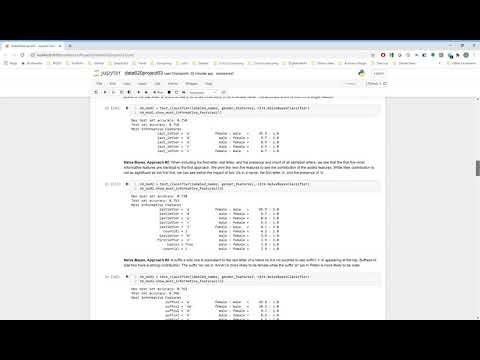

In [36]:
# Youtube raw link: https://youtu.be/hGz9f2EBC_k
from IPython.display import YouTubeVideo
YouTubeVideo('hGz9f2EBC_k')